Δ=SSE_lin - SSE_TAR = 3.119, p-valor bootstrap ≈ 0.821
            Model         SSE    sigma2         AIC         BIC
0           AR(1)  131.383975  0.376458 -336.954774 -329.244630
1  TAR(2 regimes)  128.264957  0.367521 -341.339863 -325.919575
2           LSTAR  125.518271  0.359651 -344.894586 -321.764154

AR(1) params:
      param  estimate
0    const  0.170172
1  y_{t-1}  0.824841

TAR params:
        regime  estimate slope/y_{t-1}
0  bajo (z≤c)  0.055604       0.51185
1  alto (z>c)  0.187050      0.827178
2           c  0.457041              

LSTAR params:
    param   estimate
0     b0   3.810535
1     b1   2.732204
2     d0  -3.685896
3     d1  -1.876787
4  gamma  95.228223
5      c  -1.169917


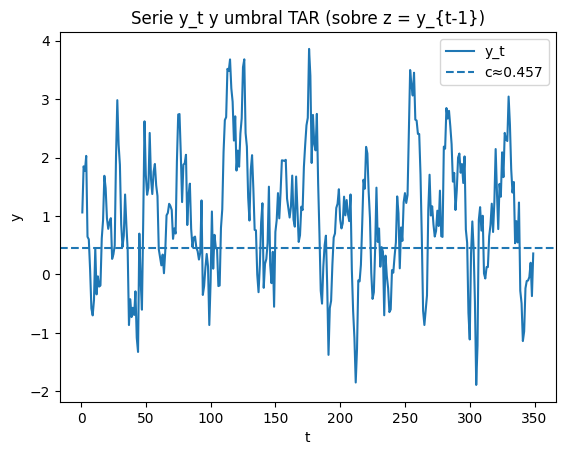

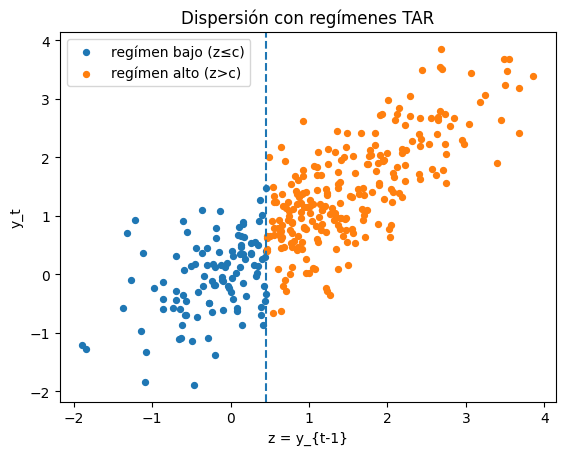

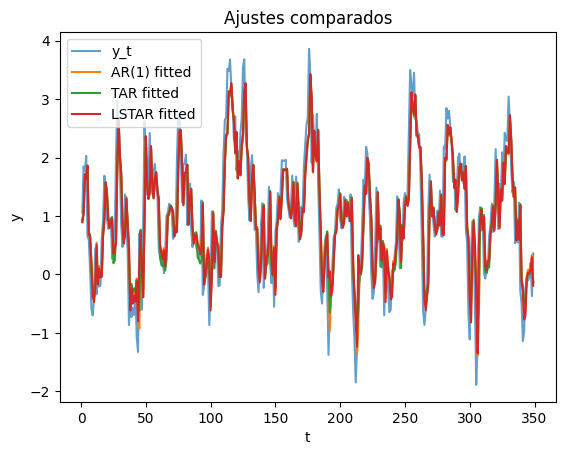

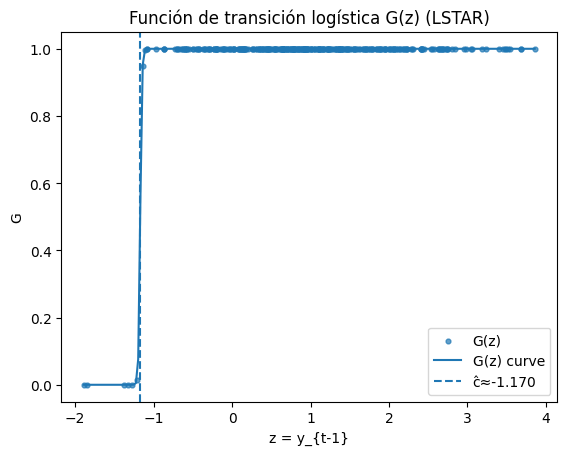

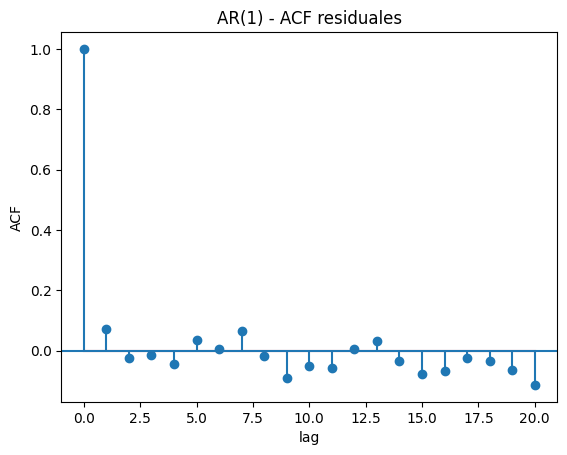

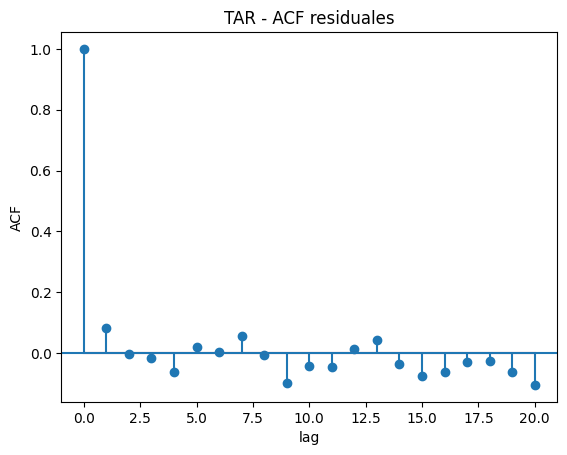

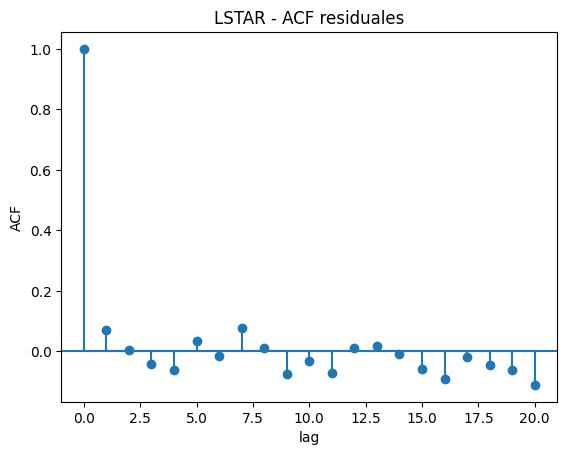

In [3]:
# =======================
# Threshold & Smooth-Transition Regression (TAR / LSTAR)
# End-to-end: simulación (opcional), AR base, TAR con búsqueda de c,
# test bootstrap lineal vs TAR, LSTAR con Gauss–Newton + LM,
# tablas, gráficos e interpretación básica.
# =======================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv, lstsq, solve, norm

# ---------- Utilidades ----------
def acf(x, nlags=20):
    x = np.asarray(x) - np.asarray(x).mean()
    ac = [1.0]; denom = (x @ x)
    for k in range(1, nlags+1):
        num = x[:-k] @ x[k:]
        ac.append(num/denom if denom != 0 else np.nan)
    return np.array(ac)

def aic_bic(resid, k):
    n = len(resid)
    sse = float(resid @ resid)
    sigma2 = sse / n
    aic = n * np.log(sigma2) + 2 * k
    bic = n * np.log(sigma2) + np.log(n) * k
    return sse, sigma2, aic, bic

# ---------- (Opcional) Simulación "económica" con transición suave ----------
def simulate_lstar_like(T=350, sigma=0.6,
                        phi1=(0.15,0.55),  # régimen "recesión": menor persistencia
                        phi2=(0.05,0.90),  # régimen "expansión": mayor persistencia
                        gamma_true=8.0, c_true=0.0, seed=42):
    rng = np.random.default_rng(seed)
    y = np.zeros(T+200)  # warmup + muestra
    for t in range(1, len(y)):
        zlag = y[t-1]
        G = 1.0 / (1.0 + np.exp(-gamma_true*(zlag - c_true)))
        mu = (phi1[0] + phi1[1]*zlag)*(1-G) + (phi2[0] + phi2[1]*zlag)*G
        y[t] = mu + rng.normal(0, sigma)
    return y[-T:]

# ---------- AR(1) base ----------
def fit_ar1(y):
    y = np.asarray(y)
    yt = y[1:]; z = y[:-1]
    X = np.column_stack((np.ones_like(z), z))
    beta = lstsq(X, yt, rcond=None)[0]
    fitted = X @ beta
    resid = yt - fitted
    n, k = X.shape
    s2 = (resid @ resid)/(n-k)
    cov = s2 * inv(X.T @ X)
    return {"beta": beta, "fitted": fitted, "resid": resid, "X": X, "cov": cov}

# ---------- TAR (p=1) con búsqueda de c ----------
def fit_tar(y, min_frac=0.15, q_low=0.15, q_high=0.85, ngrid=61):
    y = np.asarray(y)
    yt = y[1:]; z = y[:-1]  # threshold variable = y_{t-1}
    X = np.column_stack((np.ones(len(z)), z))
    n = len(z); min_obs = int(min_frac * n)
    cand = np.quantile(z, np.linspace(q_low, q_high, ngrid))
    best = None
    for c in cand:
        idx1 = z <= c; idx2 = ~idx1
        if idx1.sum() < min_obs or idx2.sum() < min_obs:
            continue
        beta1 = lstsq(X[idx1], yt[idx1], rcond=None)[0]
        beta2 = lstsq(X[idx2], yt[idx2], rcond=None)[0]
        fitted = np.empty_like(yt)
        fitted[idx1] = X[idx1] @ beta1
        fitted[idx2] = X[idx2] @ beta2
        resid = yt - fitted
        sse = float(resid @ resid)
        if (best is None) or (sse < best["sse"]):
            # EE homocedásticas por régimen
            n1, n2 = idx1.sum(), idx2.sum()
            s2_1 = ((yt[idx1]-X[idx1]@beta1)@(yt[idx1]-X[idx1]@beta1))/(n1-2)
            s2_2 = ((yt[idx2]-X[idx2]@beta2)@(yt[idx2]-X[idx2]@beta2))/(n2-2)
            cov1 = s2_1 * inv(X[idx1].T @ X[idx1])
            cov2 = s2_2 * inv(X[idx2].T @ X[idx2])
            best = dict(c=c, beta1=beta1, beta2=beta2, cov1=cov1, cov2=cov2,
                        fitted=fitted, resid=resid, sse=sse, idx1=idx1, idx2=idx2, X=X, yt=yt, z=z)
    return best

# ---------- Bootstrap: lineal vs TAR ----------
def bootstrap_tar_test(y, ar1, tar, B=200, seed=123):
    rng = np.random.default_rng(seed)
    yt = y[1:]; z = y[:-1]
    X = np.column_stack((np.ones(len(z)), z))
    sse_lin = float(ar1["resid"] @ ar1["resid"])
    sse_tar = float(tar["resid"] @ tar["resid"])
    delta_obs = sse_lin - sse_tar

    beta = ar1["beta"]; resid = ar1["resid"]; n = len(resid)
    deltas = np.empty(B)
    for b in range(B):
        e_star = rng.choice(resid, size=n, replace=True)
        y_star = (X @ beta) + e_star
        y_star_full = np.empty(n+1); y_star_full[0] = y[0]; y_star_full[1:] = y_star
        ar1_b = fit_ar1(y_star_full)
        tar_b = fit_tar(y_star_full)
        sse_lin_b = float(ar1_b["resid"] @ ar1_b["resid"])
        sse_tar_b = float(tar_b["resid"] @ tar_b["resid"])
        deltas[b] = sse_lin_b - sse_tar_b
    pval = (np.sum(deltas >= delta_obs) + 1)/(B + 1)
    return delta_obs, deltas, pval

# ---------- LSTAR: Gauss–Newton + Levenberg–Marquardt ----------
def lstar_design(y):
    y = np.asarray(y)
    yt = y[1:]; x1 = y[:-1]  # p=1
    X = np.column_stack((np.ones_like(x1), x1))
    z = x1.copy()
    return yt, X, z

def lstar_predict(theta, X, z):
    b0,b1,d0,d1,gamma,c = theta
    G = 1.0 / (1.0 + np.exp(-gamma*(z - c)))
    base = b0 + b1*X[:,1]
    trans = d0 + d1*X[:,1]
    yhat = base + trans * G
    return yhat, G

def lstar_jacobian(theta, X, z):
    b0,b1,d0,d1,gamma,c = theta
    G = 1.0 / (1.0 + np.exp(-gamma*(z - c)))
    gprime_gamma = (z - c) * G * (1 - G)
    gprime_c     = -gamma * G * (1 - G)
    ones = np.ones(len(z)); x1 = X[:,1]
    J = np.column_stack((
        ones,         # db0
        x1,           # db1
        G,            # dd0
        x1*G,         # dd1
        (d0 + d1*x1)*gprime_gamma,  # d/dgamma
        (d0 + d1*x1)*gprime_c       # d/dc
    ))
    return J, G

def lstar_fit(y, tar_init=None, max_iter=400, tol=1e-8, lam0=1e-3):
    yt, X, z = lstar_design(y)
    # Inicialización informada por TAR
    if tar_init is None:
        tar_init = fit_tar(y)
    phi1 = tar_init["beta1"]; phi2 = tar_init["beta2"]
    b0,b1 = phi1[0], phi1[1]
    d0,d1 = (phi2 - phi1)[0], (phi2 - phi1)[1]
    gamma0 = 1.5; c0 = tar_init["c"]
    theta = np.array([b0,b1,d0,d1,gamma0,c0], dtype=float)

    lam = lam0; history=[]
    for it in range(max_iter):
        yhat, G = lstar_predict(theta, X, z)
        r = yt - yhat
        J, _ = lstar_jacobian(theta, X, z)
        A = J.T @ J + lam * np.eye(J.shape[1])
        g = J.T @ r
        try:
            delta = solve(A, g)
        except np.linalg.LinAlgError:
            delta = lstsq(A, g, rcond=None)[0]
        theta_new = theta + delta
        yhat_new, _ = lstar_predict(theta_new, X, z)
        rss_old = float(r @ r); rss_new = float((yt - yhat_new) @ (yt - yhat_new))
        history.append({"iter":it, "RSS":rss_old, "lam":lam, "step_norm":norm(delta)})
        if rss_new < rss_old:
            theta = theta_new; lam = max(lam/2, 1e-9)
            if norm(delta) < tol:
                break
        else:
            lam *= 5.0

    # Varianzas
    yhat, G = lstar_predict(theta, X, z); r = yt - yhat
    J, _ = lstar_jacobian(theta, X, z)
    n, k = len(yt), len(theta)
    sigma2 = (r @ r)/(n-k)
    cov_homo = sigma2 * inv(J.T @ J)
    cov_white = inv(J.T @ J) @ (J.T @ (J * (r[:,None]**2))) @ inv(J.T @ J)
    return {"theta":theta, "cov_homo":cov_homo, "cov_white":cov_white,
            "resid":r, "yhat":yhat, "G":G, "X":X, "z":z, "history":pd.DataFrame(history)}

# ---------- Gráficos ----------
def plot_series_threshold(y, c):
    t = np.arange(1, len(y))
    plt.figure(); plt.plot(t, y[1:], label="y_t")
    plt.axhline(c, linestyle="--", label=f"c≈{c:.3f}")
    plt.title("Serie y_t y umbral TAR (sobre z = y_{t-1})"); plt.xlabel("t"); plt.ylabel("y"); plt.legend(); plt.show()

def plot_scatter_regimes(y, c):
    yt = y[1:]; z = y[:-1]
    idx1 = z <= c; idx2 = ~idx1
    plt.figure()
    plt.scatter(z[idx1], yt[idx1], label="regímen bajo (z≤c)", s=18)
    plt.scatter(z[idx2], yt[idx2], label="regímen alto (z>c)", s=18)
    plt.axvline(c, linestyle="--")
    plt.xlabel("z = y_{t-1}"); plt.ylabel("y_t"); plt.title("Dispersión con regímenes TAR"); plt.legend(); plt.show()

def plot_fits(y, ar1, tar, lstar):
    t = np.arange(1, len(y))
    plt.figure()
    plt.plot(t, y[1:], label="y_t", alpha=0.7)
    plt.plot(t, ar1["fitted"], label="AR(1) fitted")
    plt.plot(t, tar["fitted"], label="TAR fitted")
    plt.plot(t, lstar["yhat"], label="LSTAR fitted")
    plt.title("Ajustes comparados"); plt.xlabel("t"); plt.ylabel("y"); plt.legend(); plt.show()

def plot_transition_function(lstar):
    z = lstar["z"]; G = lstar["G"]; theta = lstar["theta"]
    plt.figure(); plt.scatter(z, G, s=12, alpha=0.7, label="G(z)")
    zz = np.linspace(np.min(z), np.max(z), 200)
    gamma_hat, c_hat = theta[4], theta[5]
    G_curve = 1.0 / (1.0 + np.exp(-gamma_hat*(zz - c_hat)))
    plt.plot(zz, G_curve, label="G(z) curve")
    plt.axvline(c_hat, linestyle="--", label=f"ĉ≈{c_hat:.3f}")
    plt.title("Función de transición logística G(z) (LSTAR)")
    plt.xlabel("z = y_{t-1}"); plt.ylabel("G"); plt.legend(); plt.show()

def plot_resid_acf(resid, title):
    ac = acf(resid, nlags=20)
    #plt.figure(); markerline, stemlines, baseline = plt.stem(range(len(ac)), ac, use_line_collection=True)
    plt.figure(); markerline, stemlines, baseline = plt.stem(range(len(ac)), ac)

    plt.axhline(0)
    plt.title(title + " - ACF residuales"); plt.xlabel("lag"); plt.ylabel("ACF"); plt.show()

# ---------- Ejecución de ejemplo ----------
if __name__ == "__main__":
    # 1) Datos: usa tus datos reemplazando la línea siguiente por y = tus_series.values.astype(float)
    y = simulate_lstar_like()   # <--- reemplaza por tus datos si quieres

    # 2) AR base
    ar1 = fit_ar1(y)

    # 3) TAR (p=1, threshold en y_{t-1})
    tar = fit_tar(y)  # devuelve c, coeficientes por régimen, SSE, etc.

    # 4) Test bootstrap: lineal vs TAR
    delta_obs, deltas, pval = bootstrap_tar_test(y, ar1, tar, B=200)
    print(f"Δ=SSE_lin - SSE_TAR = {delta_obs:.3f}, p-valor bootstrap ≈ {pval:.3f}")

    # 5) LSTAR (inicializado con TAR)
    lstar = lstar_fit(y, tar)

    # 6) Métricas
    sse_ar, s2_ar, aic_ar, bic_ar = aic_bic(ar1["resid"], k=2)
    sse_tar, s2_tar, aic_tar, bic_tar = aic_bic(tar["resid"], k=4)  # 2 params por régimen (const, y_{t-1})
    sse_ls, s2_ls, aic_ls, bic_ls = aic_bic(lstar["resid"], k=6)
    print(pd.DataFrame([
        {"Model":"AR(1)", "SSE":sse_ar, "sigma2":s2_ar, "AIC":aic_ar, "BIC":bic_ar},
        {"Model":"TAR(2 regimes)", "SSE":sse_tar, "sigma2":s2_tar, "AIC":aic_tar, "BIC":bic_tar},
        {"Model":"LSTAR", "SSE":sse_ls, "sigma2":s2_ls, "AIC":aic_ls, "BIC":bic_ls},
    ]))

    # 7) Tablas de parámetros
    ar_tab = pd.DataFrame({"param":["const","y_{t-1}"],
                           "estimate":ar1["beta"]})
    tar_tab = pd.DataFrame({"regime":["bajo (z≤c)","alto (z>c)","c"],
                            "estimate":[tar["beta1"][0], tar["beta2"][0], tar["c"]],
                            "slope/y_{t-1}":[tar["beta1"][1], tar["beta2"][1], ""]})
    ls_names = ["b0","b1","d0","d1","gamma","c"]
    ls_tab = pd.DataFrame({"param":ls_names, "estimate":lstar["theta"]})

    print("\nAR(1) params:\n", ar_tab)
    print("\nTAR params:\n", tar_tab)
    print("\nLSTAR params:\n", ls_tab)

    # 8) Gráficos
    plot_series_threshold(y, tar["c"])
    plot_scatter_regimes(y, tar["c"])
    plot_fits(y, ar1, tar, lstar)
    plot_transition_function(lstar)
    plot_resid_acf(ar1["resid"], "AR(1)")
    plot_resid_acf(tar["resid"], "TAR")
    plot_resid_acf(lstar["resid"], "LSTAR")
